#### Importing the dependencies

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from math import sqrt
import joblib


### Loading the dataset

In [2]:
df = pd.read_excel("pcb_scheduling_dataset.xlsx")
print("Initial dataset shape:", df.shape)
df.head()

Initial dataset shape: (200000, 9)


,priority,cpu_burst_est,io_burst_est,arrival_time,memory_req,total_cpu_used,waiting_time,turnaround_time,best_time_slice
0,1,497,226,79880,64,640,4754,5415,223
1,8,469,121,47932,499,974,3575,4727,147
2,7,481,270,13789,756,376,1924,2536,144
3,5,474,117,41141,744,571,3507,4170,213
4,5,442,123,96995,690,738,3960,4783,198


### Checking for null and duplicate values

In [3]:
print("\nNull Values :", df.isnull().sum())
print("\nDuplicate Rows :", df.duplicated().sum())


Null Values : priority           0
cpu_burst_est      0
io_burst_est       0
arrival_time       0
memory_req         0
total_cpu_used     0
waiting_time       0
turnaround_time    0
best_time_slice    0
dtype: int64

Duplicate Rows : 0


In [4]:
# Droping duplicates
df = df.drop_duplicates()
print("After dropping duplicates, shape:", df.shape)

# Filling missing values with median
df = df.fillna(df.median(numeric_only=True))

After dropping duplicates, shape: (200000, 9)


### Binning the target variable

In [5]:
df['time_slice_bin'] = pd.qcut(df['best_time_slice'], q=3, labels=['low','medium','high'])
print("\nTarget bin distribution:")
print(df['time_slice_bin'].value_counts())


Target bin distribution:
time_slice_bin
medium    66986
low       66814
high      66200
Name: count, dtype: int64


### Feature Distribution

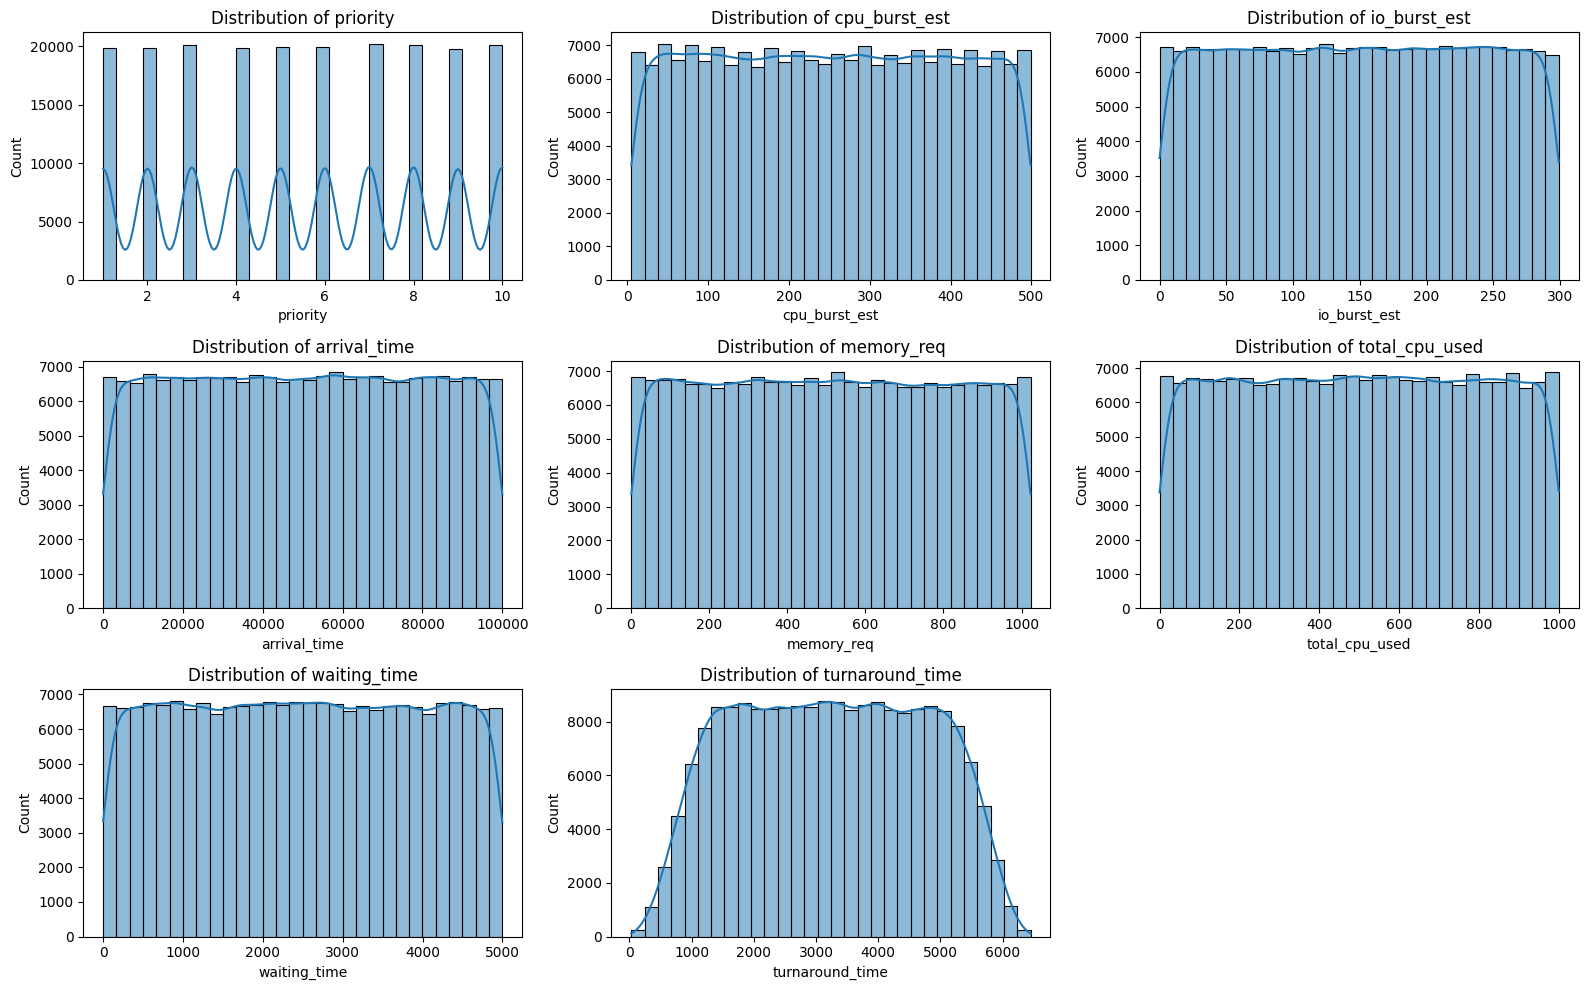

In [6]:
features = ['priority','cpu_burst_est','io_burst_est','arrival_time',
            'memory_req','total_cpu_used','waiting_time','turnaround_time']

plt.figure(figsize=(16,10))
for i, col in enumerate(features, 1):
    plt.subplot(3,3,i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

### Dependency of the execution time on different features

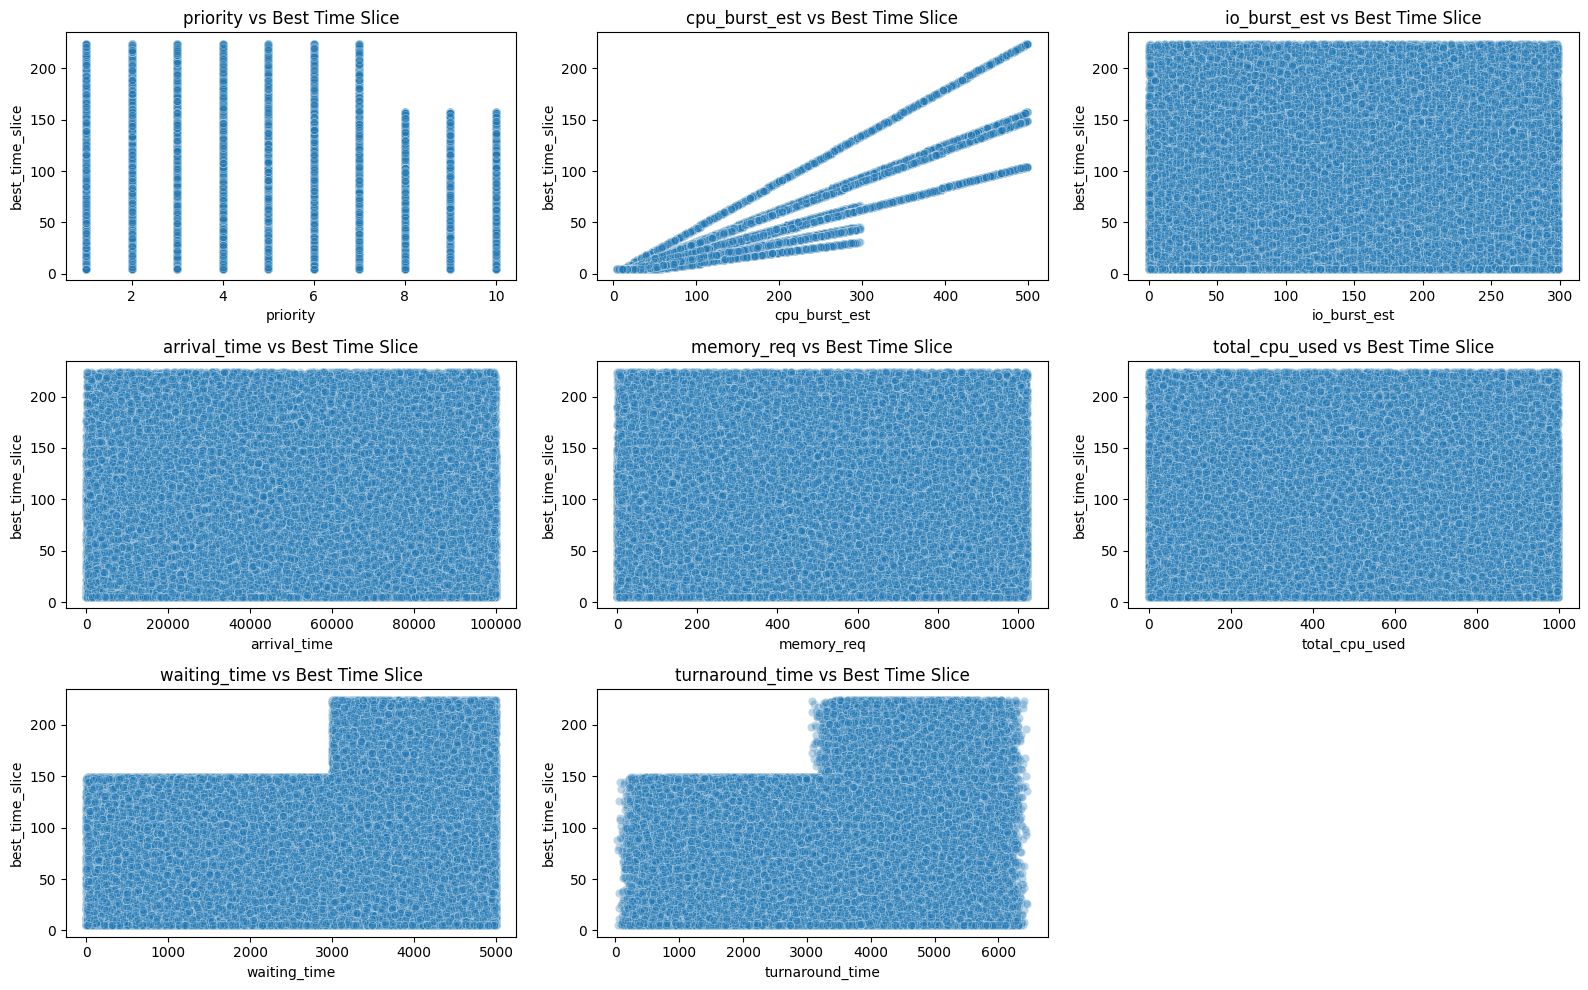

In [7]:
plt.figure(figsize=(16,10))
for i, col in enumerate(features, 1):
    plt.subplot(3,3,i)
    sns.scatterplot(x=df[col], y=df['best_time_slice'], alpha=0.3)
    plt.title(f"{col} vs Best Time Slice")
plt.tight_layout()
plt.show()

### Spliting the dataset for training and testing

In [8]:
X = df[features]
y = df['best_time_slice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
models = {
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [10]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": sqrt(mean_squared_error(y_test, y_pred)),  # manual RMSE
        "R2": r2_score(y_test, y_pred)
}

### Decision Tree Visualization

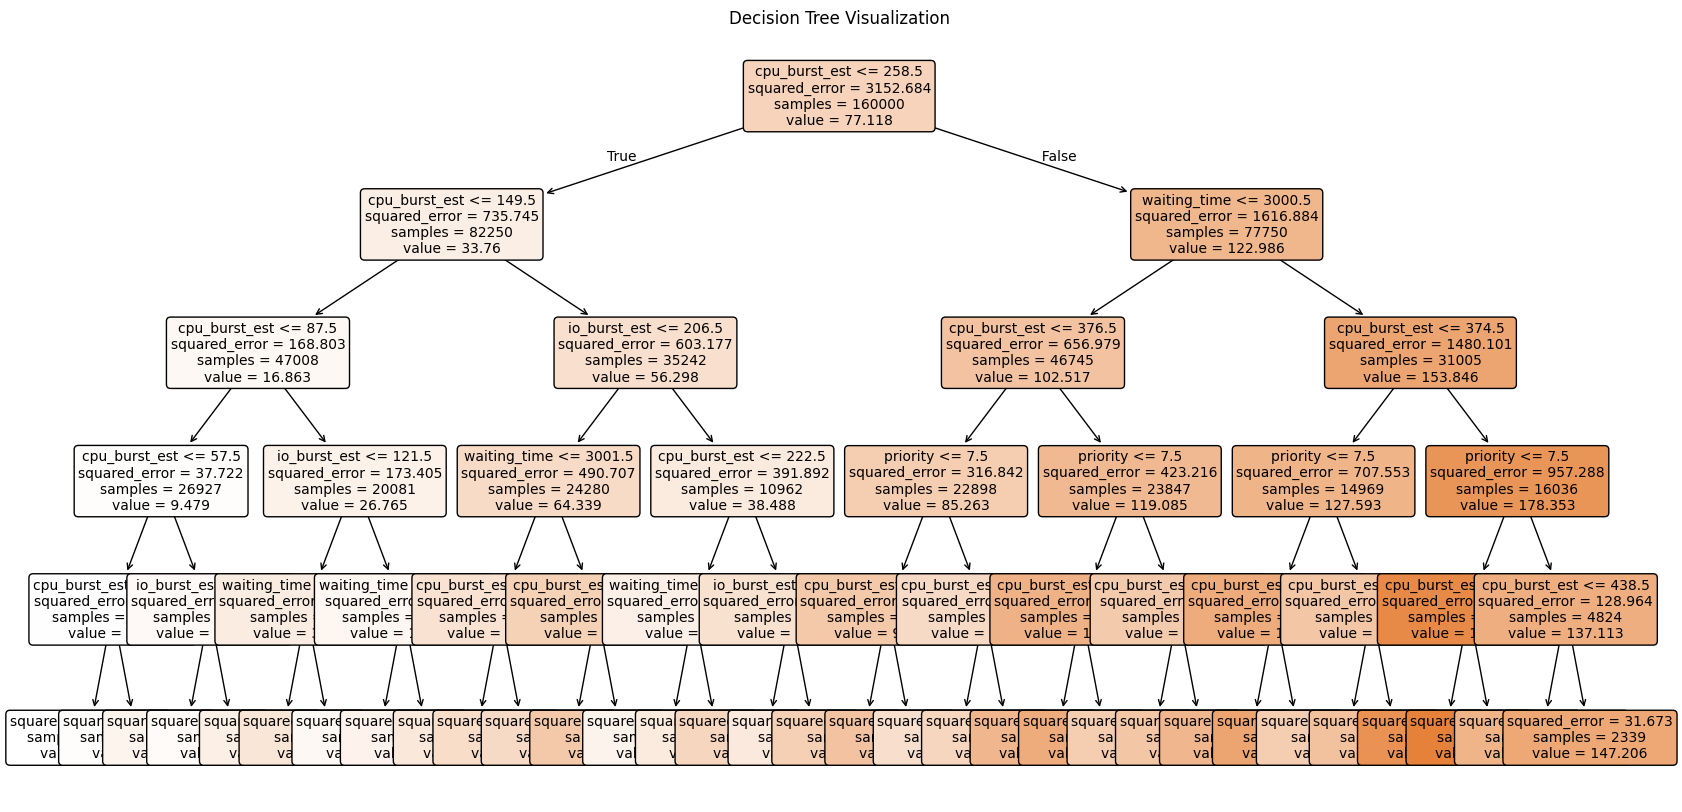

In [11]:
dt_model = models["Decision Tree"]

plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=features, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

### Compareing Models


Model Performance Comparison:
                         MAE       RMSE        R2
KNN                27.304540  33.851562  0.635845
Linear Regression  15.087943  19.116498  0.883870
Decision Tree       6.107742   8.985878  0.974340
Random Forest       0.125542   1.173128  0.999563


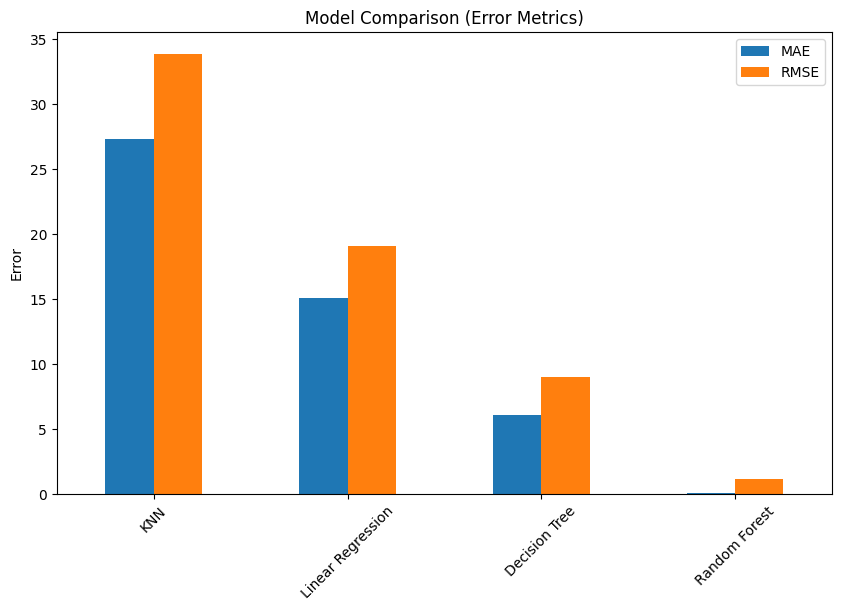

In [12]:
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Plot comparison
results_df[['MAE','RMSE']].plot(kind='bar', figsize=(10,6))
plt.title("Model Comparison (Error Metrics)")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.show()

### Feature Importance Plots for models

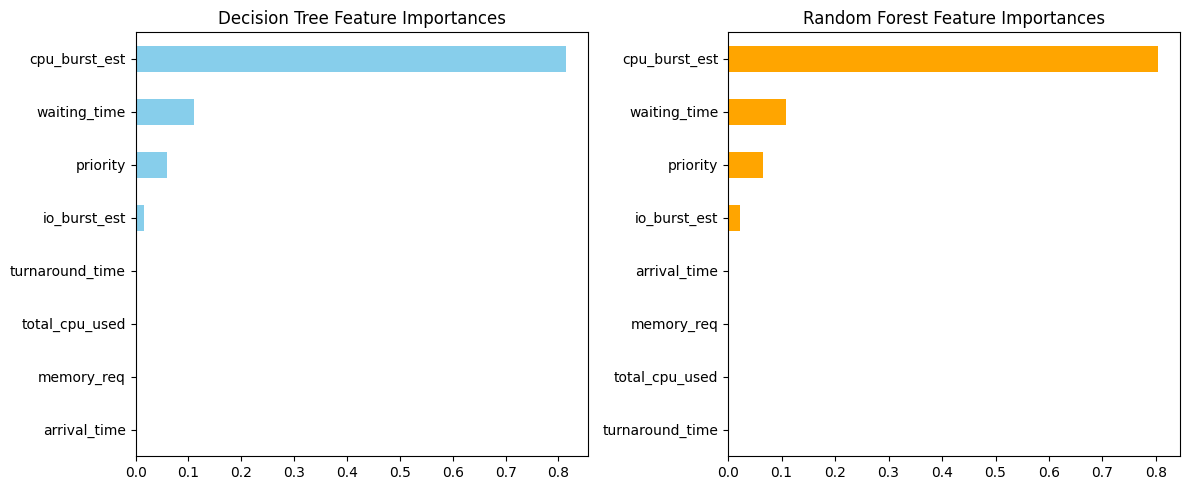

In [13]:
feat_imp_dt = pd.Series(dt_model.feature_importances_, index=features)
feat_imp_rf = pd.Series(models["Random Forest"].feature_importances_, index=features)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
feat_imp_dt.sort_values().plot(kind="barh", color="skyblue")
plt.title("Decision Tree Feature Importances")

plt.subplot(1,2,2)
feat_imp_rf.sort_values().plot(kind="barh", color="orange")
plt.title("Random Forest Feature Importances")

plt.tight_layout()
plt.show()

In [15]:
# Save Random_Forest
joblib.dump(models["Random Forest"], "Random_Forest.pkl")


['Random_Forest.pkl']